In [1]:
import os
import sys
from glob import glob
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from __future__ import unicode_literals
from IPython.core.display import display, HTML
from pprint import pprint 
import traceback

import radical.utils     as ru

import itertools
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.unicode'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, (size_x, size_y), (space_x, space_y)=(0.25,0.25)):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y), gridspec_kw={'wspace':space_x, 'hspace':space_y}, sharex=False, sharey=False)
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    return fig, axes

In [3]:
loc = '../data'
fontsize=18

In [4]:
folds = ['baseline-1', 'baseline-2', 'l2f-1', 'l2f-2']

In [5]:
def parse_uids(uid):
    new_uid = uid.split('.')[0] + '.' + uid.split('.')[-1]
    return new_uid

In [6]:
dfs = list()
for fold in folds:
    for x in glob('%s/%s/profile.*'%(loc, fold)):
        json_data = ru.read_json(x)
        df = pd.DataFrame.from_dict(json_data[json_data.keys()[0]])
        df['core'] = df['core'].apply(parse_uids)
        df['task'] = df['task'].apply(parse_uids)
        df['perf'] = df['ops']/df['exec_time']
        dfs.append(df)
    
print len(dfs)

4


In [8]:
def plotter(df):
    
    fig, axes = fig_setup(1,3,(36,8))
    title = 'Characterization of execution time given a heterogenous workload and resource'
    fig.suptitle(title)

    ax = df.plot(ax=axes[0][0], y=['start_time','end_time'], ylim=(10,90))
    ticks = [x for x in range(0, len(df['task']), 64)] + [1024]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_xlabel('Task ID')
    ax.set_ylabel('Time (seconds)')

    ax = df.plot(ax=axes[0][1], y=['ops'], ylim=(900,1200))
    ticks = [x for x in range(0, len(df['task']), 64)] + [1024]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_xlabel('Task ID')
    ax.set_ylabel('No. of operations')

    uniq_cores = set(df['core'].tolist())
    new_df = df.drop_duplicates('core')
    ax = new_df.plot(ax=axes[0][2], y=['perf'], ylim=(10,90))
    ticks = [x for x in range(0, len(new_df['core'].tolist()), 8)] + [128]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_xlabel('Core ID')
    ax.set_ylabel('No. of operations per second')
    
    return fig

/home/vivek/Research/tools/miniconda2/envs/calc/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


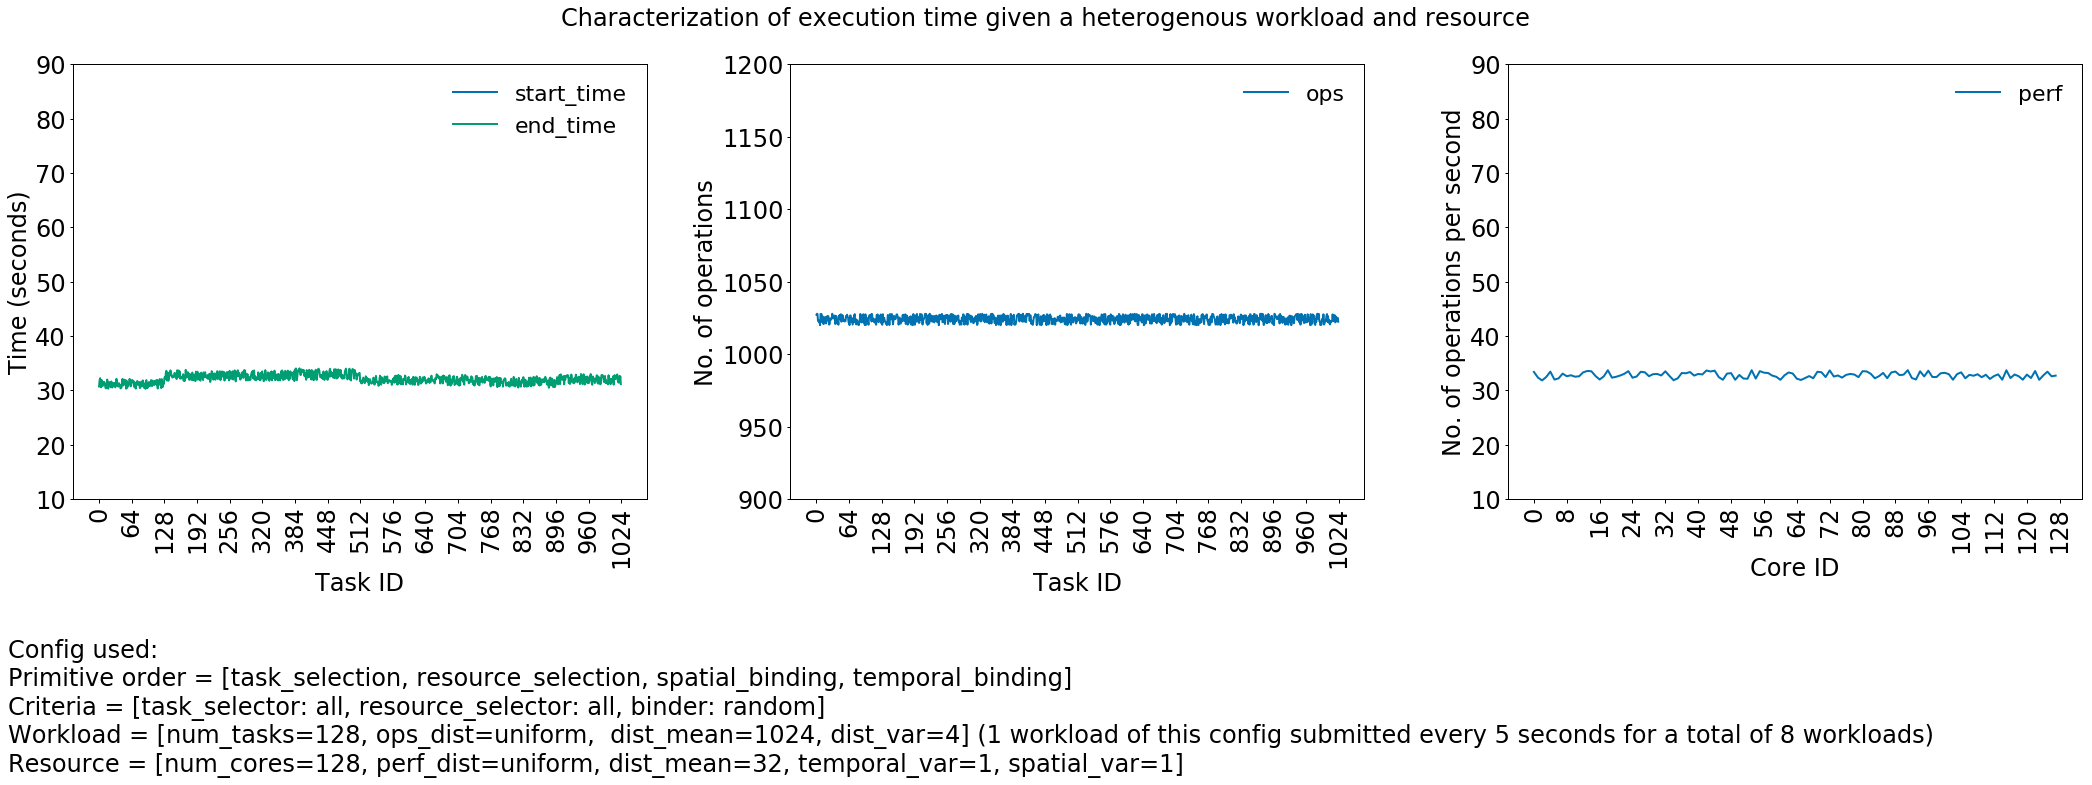

In [9]:
# Plot dataframes

df = dfs[0]
fig = plotter(df)
txt = 'Config used:'+ \
        '\nPrimitive order = [task_selection, resource_selection, spatial_binding, temporal_binding]' + \
        '\nCriteria = [task_selector: all, resource_selector: all, binder: random]' + \
        '\nWorkload = [num_tasks=128, ops_dist=uniform,  dist_mean=1024, dist_var=4] (1 workload of this config submitted every 5 seconds for a total of 8 workloads)' + \
        '\nResource = [num_cores=128, perf_dist=uniform, dist_mean=32, temporal_var=1, spatial_var=1]' 
x = fig.text(0.1,-0.35, txt)

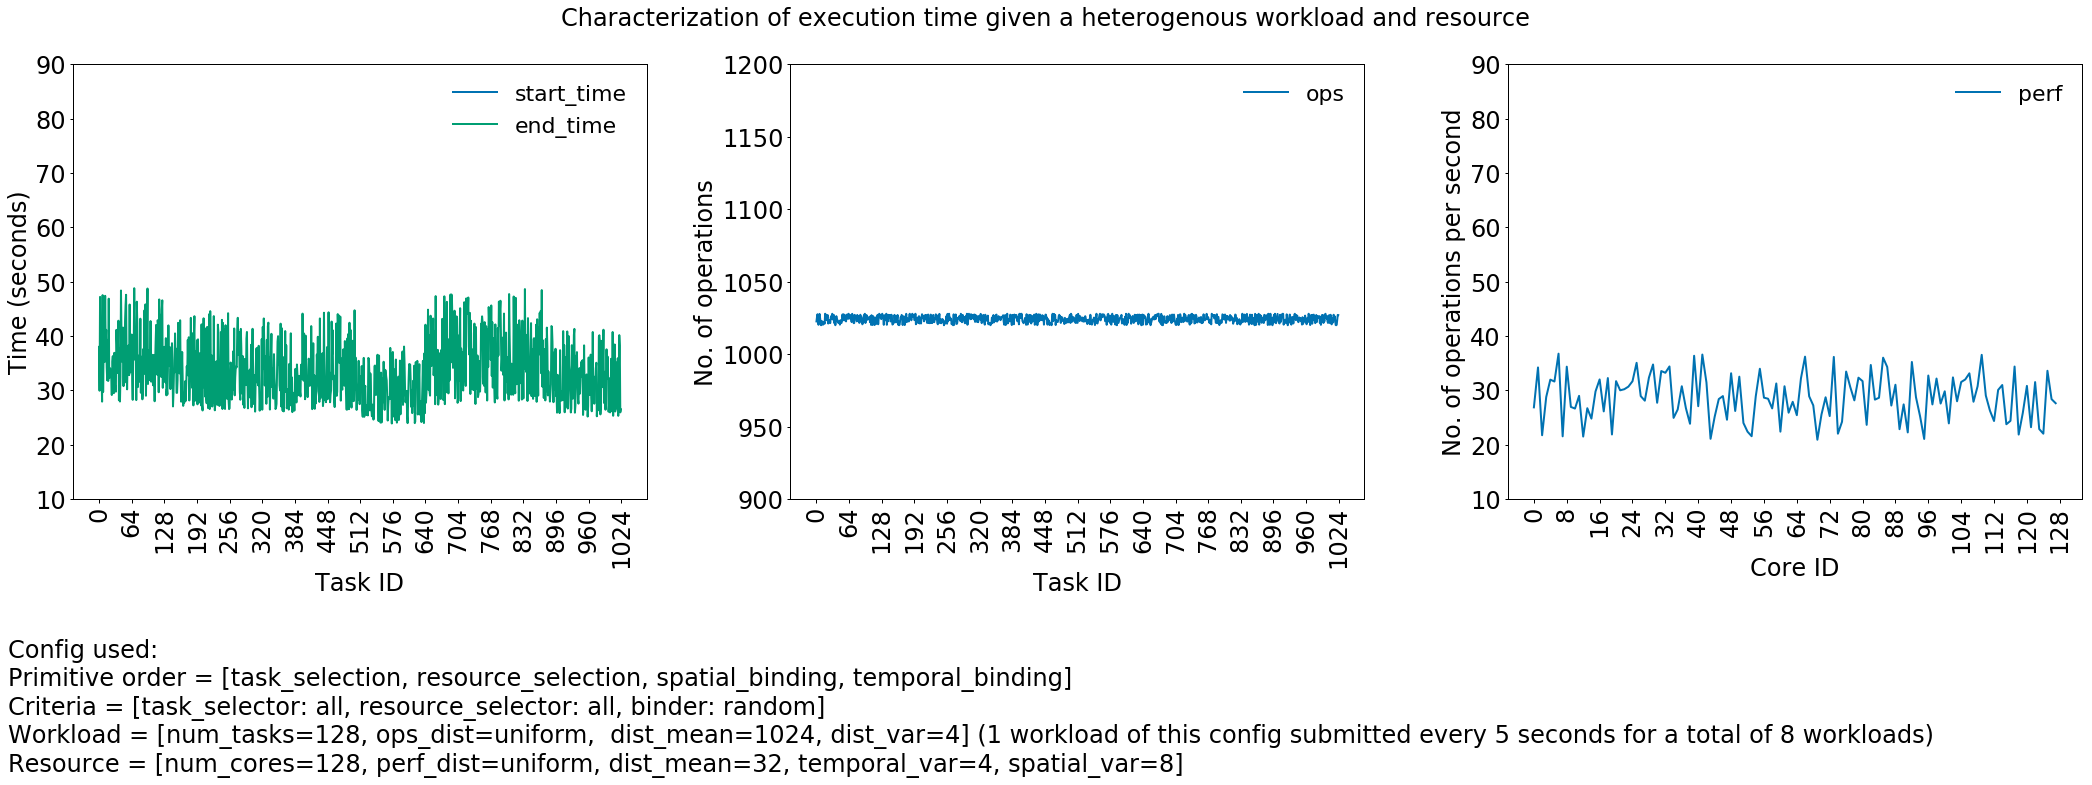

In [10]:
# Plot dataframes

df = dfs[1]
fig = plotter(df)
txt = 'Config used:'+ \
        '\nPrimitive order = [task_selection, resource_selection, spatial_binding, temporal_binding]' + \
        '\nCriteria = [task_selector: all, resource_selector: all, binder: random]' + \
        '\nWorkload = [num_tasks=128, ops_dist=uniform,  dist_mean=1024, dist_var=4] (1 workload of this config submitted every 5 seconds for a total of 8 workloads)' + \
        '\nResource = [num_cores=128, perf_dist=uniform, dist_mean=32, temporal_var=4, spatial_var=8]' 
x = fig.text(0.1,-0.35, txt)

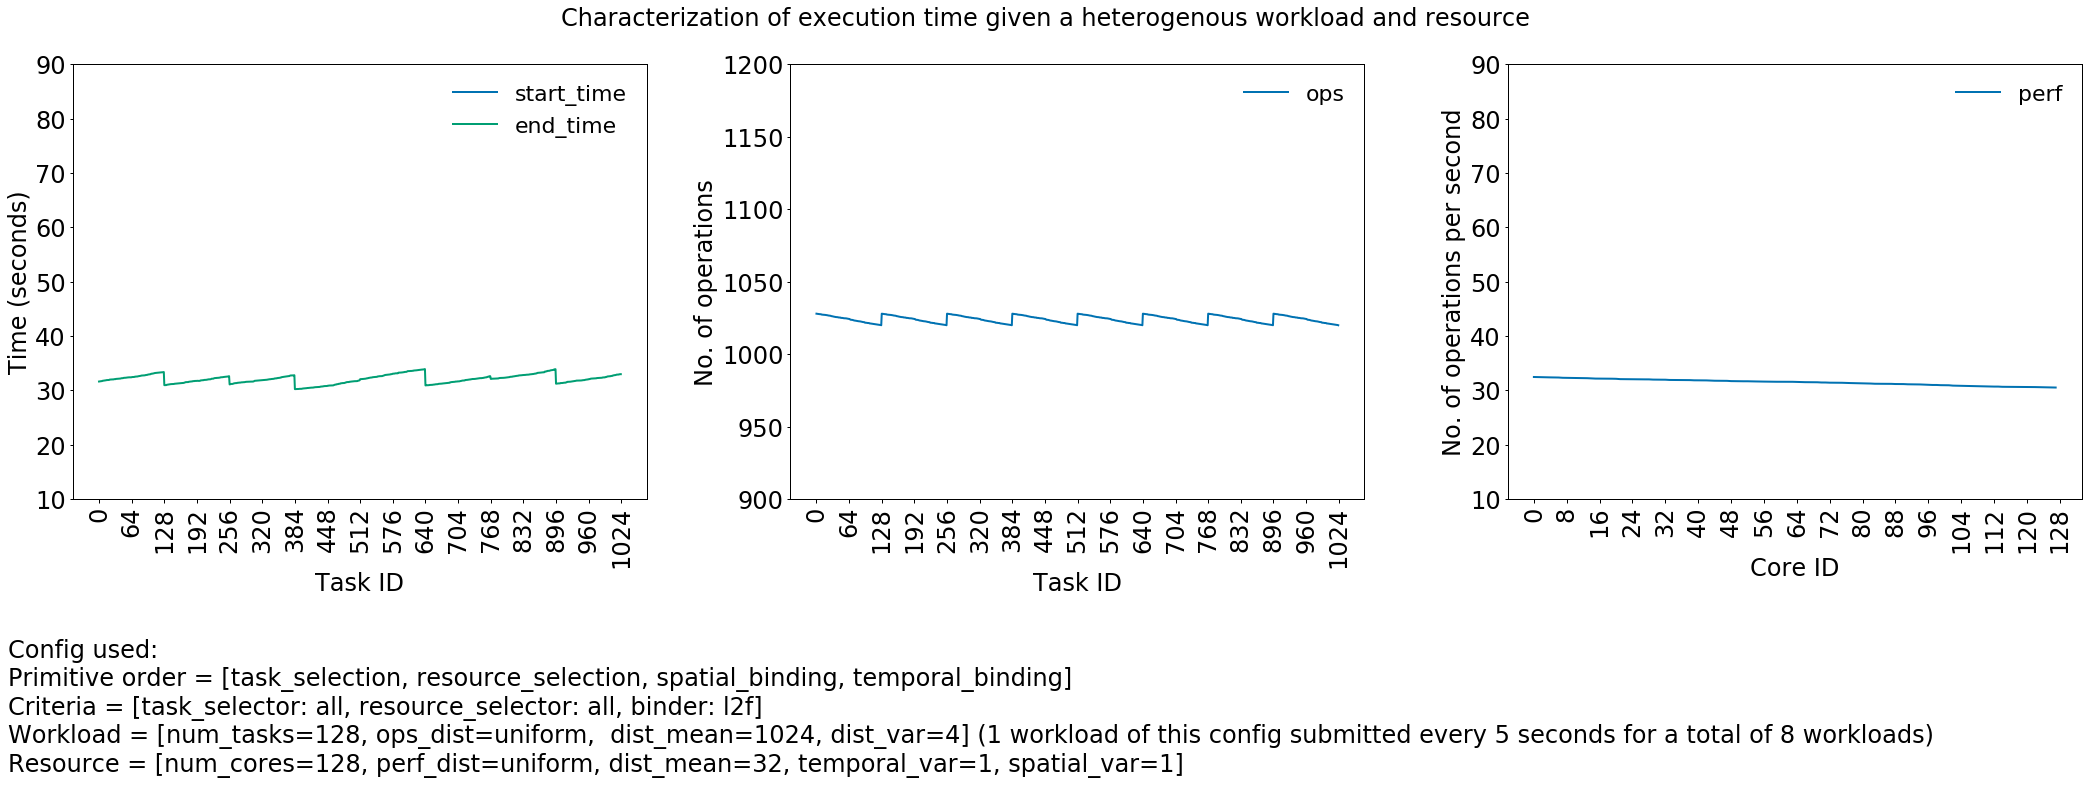

In [11]:
# Plot dataframe

df = dfs[2]
fig = plotter(df)
txt = 'Config used:'+ \
        '\nPrimitive order = [task_selection, resource_selection, spatial_binding, temporal_binding]' + \
        '\nCriteria = [task_selector: all, resource_selector: all, binder: l2f]' + \
        '\nWorkload = [num_tasks=128, ops_dist=uniform,  dist_mean=1024, dist_var=4] (1 workload of this config submitted every 5 seconds for a total of 8 workloads)' + \
        '\nResource = [num_cores=128, perf_dist=uniform, dist_mean=32, temporal_var=1, spatial_var=1]' 
x=fig.text(0.1,-0.35, txt)

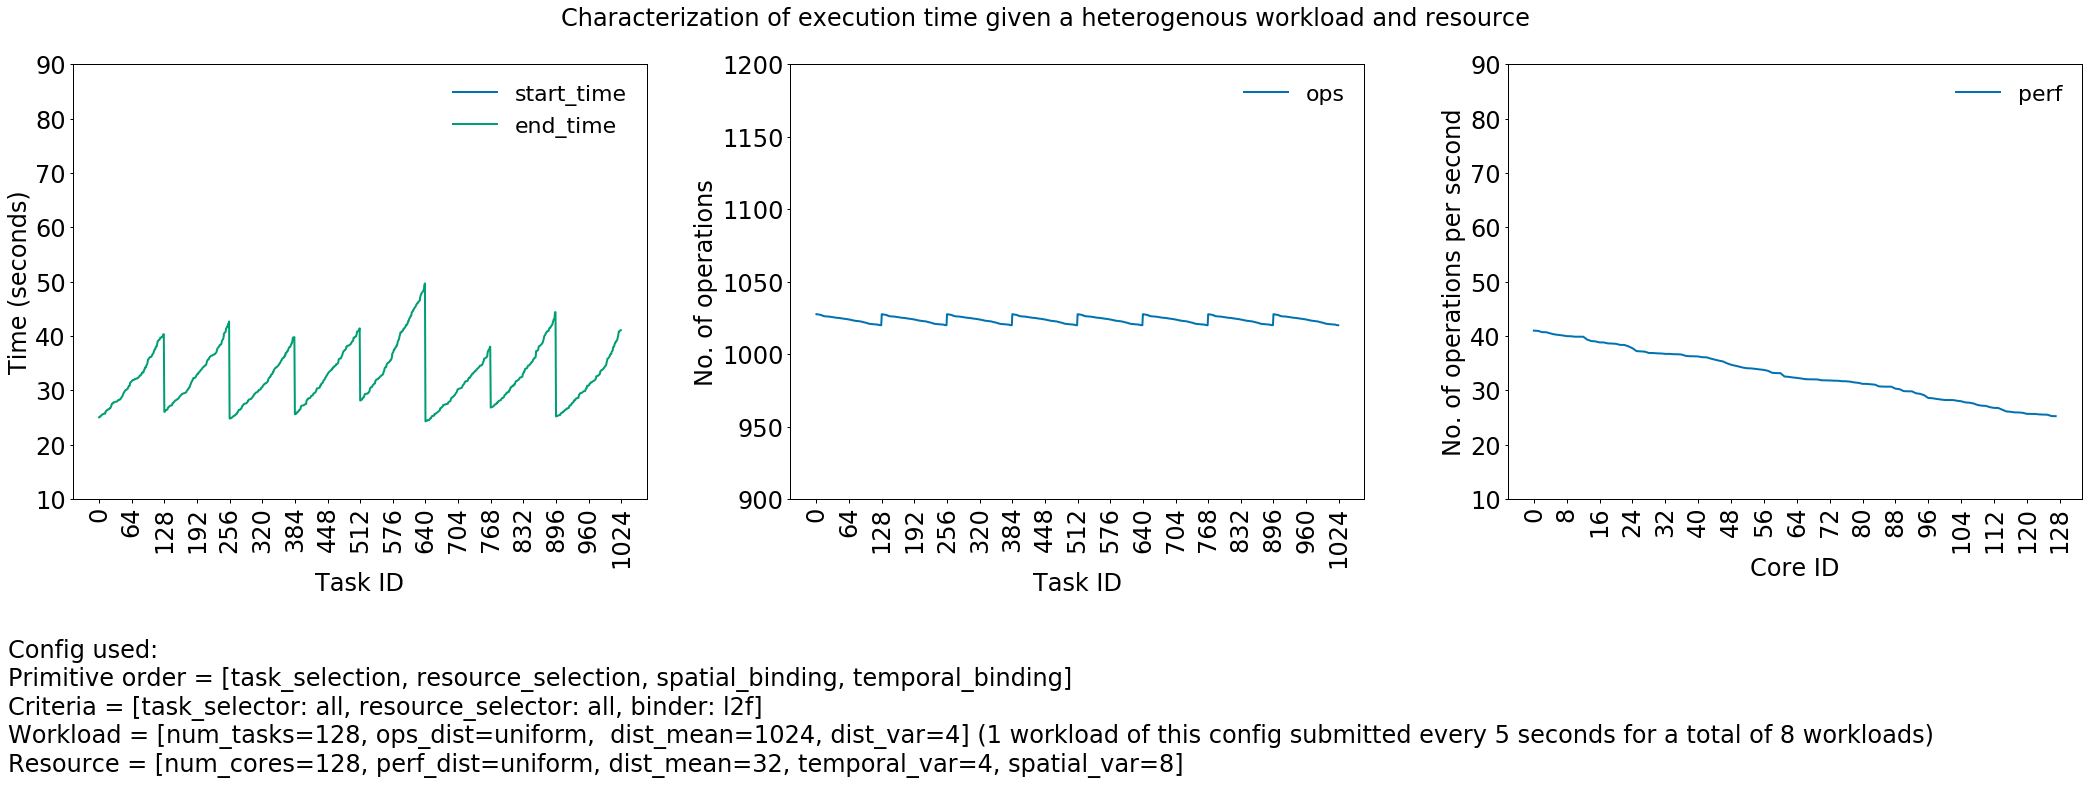

In [12]:
# Plot dataframe

df = dfs[3]
fig = plotter(df)
txt = 'Config used:'+ \
        '\nPrimitive order = [task_selection, resource_selection, spatial_binding, temporal_binding]' + \
        '\nCriteria = [task_selector: all, resource_selector: all, binder: l2f]' + \
        '\nWorkload = [num_tasks=128, ops_dist=uniform,  dist_mean=1024, dist_var=4] (1 workload of this config submitted every 5 seconds for a total of 8 workloads)' + \
        '\nResource = [num_cores=128, perf_dist=uniform, dist_mean=32, temporal_var=4, spatial_var=8]' 
x = fig.text(0.1,-0.35, txt)